In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
# # Import data
# df = pd.read_csv('training_project2.csv')

# # Drop date variable
# df = df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'dividend', 'split'])

# # Checking dataset
# # print(df[df['id'] == 11477]['id'])

# # Split data by IDs and write to different files
# dfs = dict(tuple(df.groupby('id')))
# list_df = [dfs[x] for x in dfs]
# for index, df in enumerate(list_df):
#     df['moving_average'] = df['adjusted_close'].rolling(5).mean()
#     df.to_csv("data_by_id/" + str(index) + ".csv", index=False)

In [86]:
# import id 0, given data
dataset = pd.read_csv('data_by_id/0.csv',index_col="time",parse_dates=True)
# df = pd.read_csv('data_by_id/0.csv', index_col="time",parse_dates=True)
n = dataset['adjusted_close'].count()
dataset = dataset.iloc[:n-4,] # for some reason the last 4 are cut off of the factor, so subset by 4 here to match size

# import id 0, factor variable
df = pd.read_csv('0.csv',index_col="time",parse_dates=True)
df.tail(8)
dataset.tail(8)

,adjusted_open,adjusted_high,adjusted_low,adjusted_close,adjusted_volume,id,moving_average
time,,,,,,,
2017-12-13,66.764149,67.191169,66.178237,66.217960,1684618.0,0,66.501978
2017-12-14,66.466227,66.625119,65.910108,66.049138,1774564.0,0,66.462255
2017-12-15,66.416574,67.389783,66.227890,67.141516,2871893.0,0,66.507936
2017-12-18,67.767150,68.035279,67.012416,67.191169,2306264.0,0,66.639022
2017-12-19,67.240823,67.578467,67.022347,67.280545,1448362.0,0,66.776066
2017-12-20,67.568536,67.667843,66.694634,66.932971,1363529.0,0,66.919068
2017-12-21,67.111723,67.399714,66.801786,67.052139,1502218.0,0,67.119668
2017-12-22,66.992555,67.071901,66.396712,66.883317,1221315.0,0,67.068028


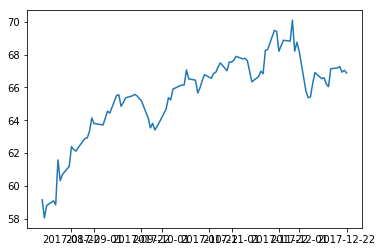

In [48]:
just_the_close = dataset['adjusted_close']
just_the_close = pd.DataFrame(just_the_close)
plt.plot(just_the_close[n-100:])
plt.show()

In [49]:
n = dataset['adjusted_close'].count()

print(n)

n2 = df.count()
print(n2)

4553
factor_analyzed    4553
dtype: int64


In [105]:
#training_set=dataset['factor_analyzed']
#training_set=pd.DataFrame(training_set)
#training=df['adjusted_open']
#training=pd.DataFrame(training)
# Feature Scaling
#sc = MinMaxScaler(feature_range = (0, 1))
#training_set_scaled = sc.fit_transform(training_set)
#training_scaled=sc.fit_transform(training)

#training_set_scaled.plot(figsize=(16,6))
#training_scaled.plot(figsize=(16,6))

In [57]:
# training_set=dataset['adjusted_close'] # using just the adjusted close actually works best ...
training_set = df['factor_analyzed'] # try with the factor
training_set=pd.DataFrame(training_set)
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4553 entries, 1999-11-19 to 2017-12-22
Data columns (total 1 columns):
factor_analyzed    4553 non-null float64
dtypes: float64(1)
memory usage: 71.1 KB


In [63]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
just_the_close_scaled = sc.fit_transform(just_the_close)

In [64]:
just_the_close.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4553 entries, 1999-11-19 to 2017-12-22
Data columns (total 1 columns):
adjusted_close    4553 non-null float64
dtypes: float64(1)
memory usage: 71.1 KB


In [65]:
# # Creating a data structure with 60 timesteps and 1 output
# X_train = []
# y_train = []
# for i in range(60, n-100):
#     X_train.append(training_set_scaled[i-60:i, 0])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)

# # Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# ===== use actual close for y, and factor variable for x
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, n-100):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(just_the_close_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [66]:
# Initialising the RNN
regressor = Sequential()

In [67]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [72]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
4393/4393 [==============================] - 22s 5ms/step - loss: 0.0012
Epoch 2/10
4393/4393 [==============================] - 21s 5ms/step - loss: 8.5466e-04
Epoch 3/10
4393/4393 [==============================] - 21s 5ms/step - loss: 7.1157e-04
Epoch 4/10
4393/4393 [==============================] - 21s 5ms/step - loss: 5.2349e-04
Epoch 5/10
4393/4393 [==============================] - 21s 5ms/step - loss: 5.1330e-04
Epoch 6/10
4393/4393 [==============================] - 21s 5ms/step - loss: 3.9357e-04
Epoch 7/10
4393/4393 [==============================] - 21s 5ms/step - loss: 4.9076e-04
Epoch 8/10
4393/4393 [==============================] - 271s 62ms/step - loss: 3.5690e-04
Epoch 9/10
4393/4393 [==============================] - 20s 5ms/step - loss: 3.0488e-04
Epoch 10/10
4393/4393 [==============================] - 20s 5ms/step - loss: 2.6272e-04


In [15]:

# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
#dataset_test = pd.read_csv('Google_Stock_Price_Test.csv',index_col="Date",parse_dates=True)

In [73]:
X_test = []
for i in range(n-100, n):
    X_test.append(training_set_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [74]:
predicted_stock_price=pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
0    100 non-null float32
dtypes: float32(1)
memory usage: 480.0 bytes


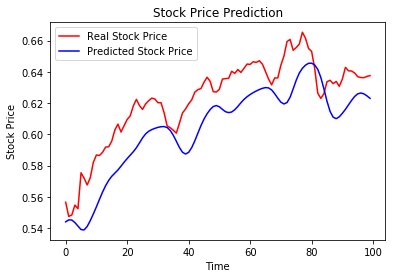

In [76]:
# Visualising the results
plt.plot(training_set_scaled[n-100:], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

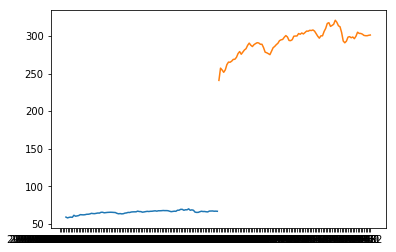

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 4457 to 4552
Data columns (total 1 columns):
predicted_price    96 non-null float64
dtypes: float64(1)
memory usage: 1.5+ KB


,predicted_price
4548,300.683191
4549,300.291393
4550,300.247848
4551,300.824247
4552,301.164428


In [177]:
# put predicted price and actual price in same df
time_index = just_the_close.index
predicted_stock_price.index = time_index[n-100-4:]
together_df = pd.concat([just_the_close[n-100:], predicted_stock_price], axis = 1)

# Index([u'adjusted_close', u'factor'],dtype='object')

together_df.rename(index=str, columns={0: "predicted_price"}, inplace = True)
together_df.head()

# ERROR
### having trouble with the scaling, putting predicted price (using factor) to close-prices
close_unscaled = sc.inverse_transform(training_set)
close_unscaled = pd.DataFrame(close_unscaled)
close_unscaled.rename(index=str, columns={0: "predicted_price"}, inplace = True)
close_unscaled = close_unscaled[n-100:]
plt.plot(together_df['adjusted_close'])
plt.plot(close_unscaled['predicted_price'])
plt.show()
close_unscaled.info()
close_unscaled.tail()

In [178]:
# make new column with 2% price predictions 5 days in future from time t

together_df.head()
together_df = together_df.assign(close_lag_5 = lambda x: x.adjusted_close.shift(-5))
together_df = together_df.assign(predict_lag_5 = lambda x: x.predicted_price.shift(-5))
together_df = together_df.assign(actual_percent = lambda x: (x.close_lag_5 - x.adjusted_close)/x.adjusted_close)
together_df = together_df.assign(predict_percent = lambda x: (x.predict_lag_5 - x.predicted_price)/x.predicted_price)
together_df = together_df.assign(up_two = lambda x: (x.actual_percent > 0.02).astype(int))
together_df = together_df.assign(up_three = lambda x: (x.actual_percent > 0.03).astype(int))
together_df = together_df.assign(up_five = lambda x: (x.actual_percent > 0.05).astype(int))
together_df = together_df.assign(predict_up_two = lambda x: (x.predict_percent > 0.02).astype(int))
together_df = together_df.assign(predict_up_three = lambda x: (x.predict_percent > 0.03).astype(int))
together_df = together_df.assign(predict_up_five = lambda x: (x.predict_percent > 0.05).astype(int))

# print(together_df.iloc[2,'up_two'])

# for t in range(0,n-4):
#     together_df.iloc[t,'up_two'] = t
    
together_df.head(15)

,adjusted_close,predicted_price,close_lag_5,predict_lag_5,actual_percent,predict_percent,up_two,up_three,up_five,predict_up_two,predict_up_three,predict_up_five
time,,,,,,,,,,,,
2017-08-03 00:00:00,NaN,0.543962,58.046041,0.539034,NaN,-0.009059,0,0,0,0,0,0
2017-08-04 00:00:00,NaN,0.545223,58.799243,0.538801,NaN,-0.011778,0,0,0,0,0,0
2017-08-07 00:00:00,NaN,0.545134,59.086648,0.541016,NaN,-0.007554,0,0,0,0,0,0
2017-08-08 00:00:00,NaN,0.543516,58.848795,0.544741,NaN,0.002255,0,0,0,0,0,0
2017-08-09 00:00:00,59.146111,0.541240,61.584105,0.549011,0.041220,0.014359,1,1,0,0,0,0
2017-08-10 00:00:00,58.046041,0.539034,60.315555,0.553583,0.039099,0.026992,1,1,0,1,0,0
2017-08-11 00:00:00,58.799243,0.538801,60.702066,0.558388,0.032361,0.036352,1,1,0,1,1,0
2017-08-14 00:00:00,59.086648,0.541016,61.187683,0.563028,0.035559,0.040687,1,1,0,1,1,0
2017-08-15 00:00:00,58.848795,0.544741,62.396769,0.567118,0.060290,0.041078,1,1,1,1,1,0


In [173]:
(61.584105 - 59.146111)/59.146111

0.04121985298407876